In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ambient_temperature_system_failure.csv to ambient_temperature_system_failure (1).csv


In [ ]:
df = pd.read_csv("/content/ambient_temperature_system_failure.csv")
df.head()

timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551

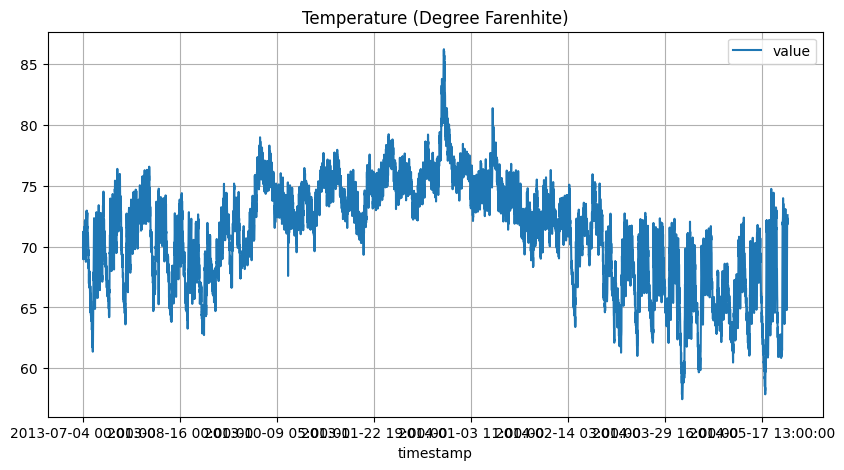

In [ ]:
figsize=(10,5)
df.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)')
plt.grid()
plt.show()

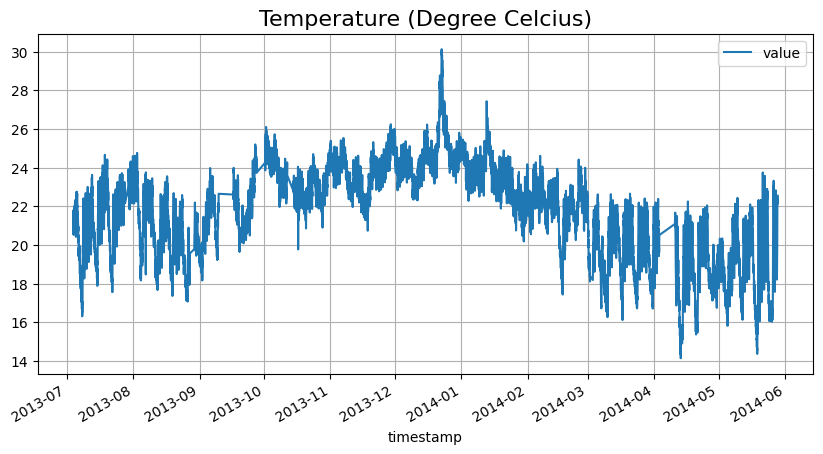

In [ ]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize)
plt.title('Temperature (Degree Celcius)', fontsize=16)
plt.grid()
plt.show()

In [ ]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [ ]:
# Anomaly estimated population
outliers_fraction = 0.01

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

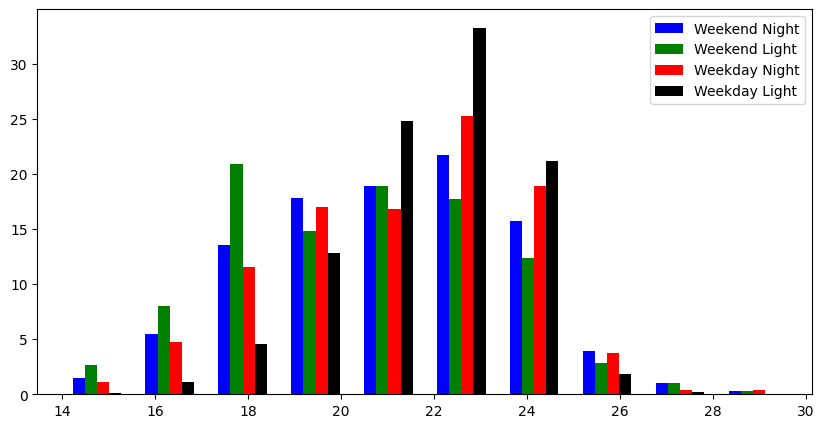

In [ ]:
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

In [ ]:
#Preparing the data for our LSTM model
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled =min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [ ]:
prediction_time=1
testdatasize=1000
unroll_length=50
testdatacut= testdatasize+unroll_length+1

In [ ]:
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [ ]:
def unroll(data,sequence_length=30):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [ ]:
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [ ]:
model = Sequential()

model.add(LSTM(units=100,return_sequences=True,input_dim=x_train.shape[-1]))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.029189348220825195


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 100)         42400     
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 122901 (480.08 KB)
Trainable params: 122

In [ ]:
history=model.fit(x_train, y_train, batch_size=3028, epochs=30, validation_split=0.1)

Epoch 1/30
2/2 [==============================] - 12s 5s/step - loss: 0.6194 - val_loss: 0.6447
Epoch 2/30
2/2 [==============================] - 6s 3s/step - loss: 0.2112 - val_loss: 0.5086
Epoch 3/30
2/2 [==============================] - 7s 4s/step - loss: 0.1783 - val_loss: 0.2859
Epoch 4/30
2/2 [==============================] - 6s 3s/step - loss: 0.1079 - val_loss: 0.2337
Epoch 5/30
2/2 [==============================] - 7s 3s/step - loss: 0.1071 - val_loss: 0.2162
Epoch 6/30
2/2 [==============================] - 6s 3s/step - loss: 0.1226 - val_loss: 0.2087
Epoch 7/30
2/2 [==============================] - 7s 3s/step - loss: 0.0987 - val_loss: 0.1953
Epoch 8/30
2/2 [==============================] - 6s 3s/step - loss: 0.0930 - val_loss: 0.1818
Epoch 9/30
2/2 [==============================] - 7s 3s/step - loss: 0.0879 - val_loss: 0.1719
Epoch 10/30
2/2 [==============================] - 6s 3s/step - loss: 0.0852 - val_loss: 0.1614
Epoch 11/30
2/2 [==============================]

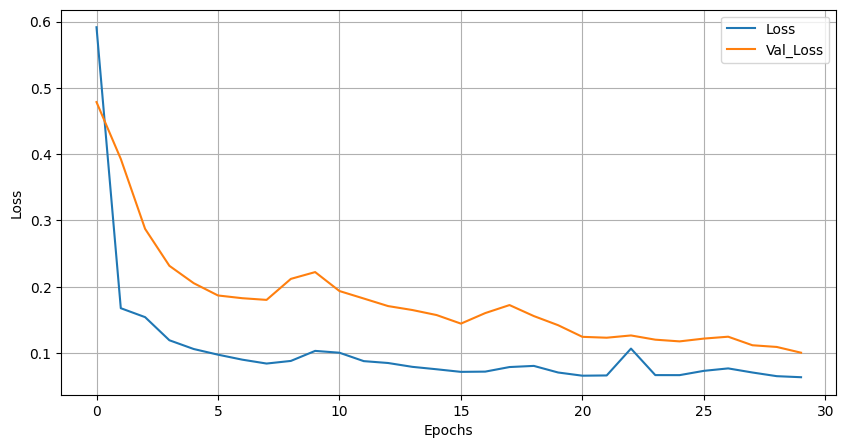

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

32/32 [==============================] - 2s 25ms/step


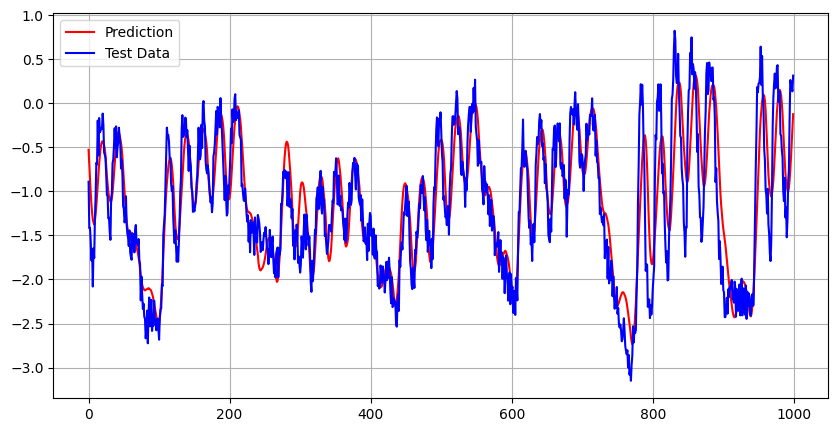

In [ ]:
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


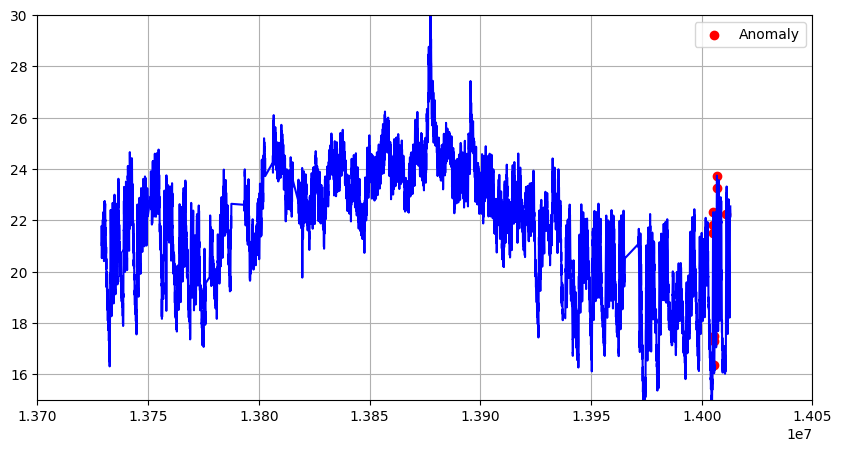

In [ ]:
plt.figure(figsize=(10,5))
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.grid()
plt.legend()